#### <b> Introduction </b>

The aim of this goal is to an end-to-end Machine Learning pipeline to predict the Length Of Stay (LOS) using the MIMIC-III dataset


In [1]:
import xgboost as xgb

### <b> PySpark vs GCP </b>

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, when, datediff, hour, minute, count, avg, stddev, min, max, desc, countDistinct, sum as spark_sum, max as spark_max
import os
import time
import matplotlib.pyplot as plt
import psutil

#### <b> PySpark </b>

In [18]:
# Print your system's available memory
mem_info = psutil.virtual_memory()
print(f"Total memory: {mem_info.total / (1024**3):.2f} GB")
print(f"Available memory: {mem_info.available / (1024**3):.2f} GB")

Total memory: 18.00 GB
Available memory: 6.38 GB


#### <b> Spark and CSV data loading functions </b>

In [19]:
# spark.driver.memory: Used by the main program that orchestrates tasks (Stores task results, coordinates actions, loads final DataFrames)
# spark.executor.memory: Used by worker processes that execute individual tasks (Data processing, transformations, aggregations, shuffling)
# spark.driver.maxResultSize: limits the total size of serialized results that can be returned to the driver from all partitions in a single Spark operation
def initialize_spark():
    '''
    Description: Initialize Spark Session

    Arguments: 
        -None
    Output: 
        -Spark session
    '''
    spark = SparkSession.builder \
                        .appName("MIMIC-III LOS Prediction") \
                        .config("spark.driver.memory", "12g") \
                        .config("spark.executor.memory", "12g") \
                        .config("spark.driver.maxResultSize", "6g") \
                        .getOrCreate()

    # Check initialization
    print("Success! Spark is working.")
    print(f"Spark version: {spark.version}\n")

    return spark

def load_csv_table(spark, csv_dir, table_name):
    """Load a CSV table with performance timing."""
    csv_path = os.path.join(csv_dir, f"{table_name.upper()}.csv")
    
    print(f"Loading {table_name} from CSV...")
    start_time = time.time()
    
    
    df = spark.read.csv(csv_path, header=True, inferSchema=True)
    df = df.drop("ROW_ID")
    
    # Force action to measure full load time
    count = df.count()
    end_time = time.time()
    
    print(f"Loaded {table_name}: {count} rows in {end_time - start_time:.2f} seconds")
    return df

In [20]:
spark = initialize_spark()

init_time = time.time()

# Load tables
admissions_df = load_csv_table(spark, "../data/raw", "admissions")
print("\n")
callout_df = load_csv_table(spark, "../data/raw", "callout")
print("\n")
chart_events_df = load_csv_table(spark, "../data/raw", "chartevents")
print("\n")
d_icd_diagnoses = load_csv_table(spark, "../data/raw", "d_icd_diagnoses")
print("\n")
d_items_df = load_csv_table(spark, "../data/raw", "d_items")
print("\n")
diagnoses_icd_df = load_csv_table(spark, "../data/raw", "diagnoses_icd")
print("\n")
icustays_df = load_csv_table(spark, "../data/raw", "icustays")
print("\n")
patients_df = load_csv_table(spark, "../data/raw", "patients")
print("\n")
services_df = load_csv_table(spark, "../data/raw", "services")
print("\n")

final_time = time.time() - init_time

print(f"Total loading time: {final_time}")

Success! Spark is working.
Spark version: 3.5.5

Loading admissions from CSV...
Loaded admissions: 58976 rows in 0.33 seconds


Loading callout from CSV...
Loaded callout: 34499 rows in 0.24 seconds


Loading chartevents from CSV...


Loaded chartevents: 330712483 rows in 87.03 seconds


Loading d_icd_diagnoses from CSV...
Loaded d_icd_diagnoses: 14567 rows in 0.08 seconds


Loading d_items from CSV...
Loaded d_items: 12487 rows in 0.09 seconds


Loading diagnoses_icd from CSV...
Loaded diagnoses_icd: 651047 rows in 0.21 seconds


Loading icustays from CSV...
Loaded icustays: 61532 rows in 0.15 seconds


Loading patients from CSV...
Loaded patients: 46520 rows in 0.13 seconds


Loading services from CSV...
Loaded services: 73343 rows in 0.13 seconds


Total loading time: 88.40759181976318


#### <b> Join  ICUSTAYS and ADMISSIONS </b>
* Get relevant information from patients that were admitted to the ICU when they went to the hospital, and exclude those that didn't

In [21]:
new_icustays_df = icustays_df.join(admissions_df, on=["SUBJECT_ID", "HADM_ID"], how="left") 

#### Join <b> new ICU data with the PATIENTS info </b>

In [22]:
patients_full_info_df = new_icustays_df.join(patients_df, on="SUBJECT_ID", how="left")

In [23]:
patients_full_info_df.show(5)

+----------+-------+----------+----------+--------------+-------------+------------+-----------+-------------------+-------------------+------+-------------------+-------------------+-------------------+--------------+--------------------+--------------------+---------+--------+-----------------+--------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-------------------+-------------------+-------------------+-------------------+-----------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|  DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|   LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|  DISCHARGE_LOCATION|INSURANCE|LANGUAGE|         RELIGION|MARITAL_STATUS|           ETHNICITY|          EDREGTIME|          EDOUTTIME|           DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|GENDER|                DOB| 

In [24]:
# Check if row counts are the same
print(f"ICUSTAYS count: {icustays_df.count()}")
print(f"After joining ADMISSIONS: {new_icustays_df.count()}")
print(f"After joining PATIENTS: {patients_full_info_df.count()}")


ICUSTAYS count: 61532
After joining ADMISSIONS: 61532
After joining PATIENTS: 61532


<b> Join DIAGNOSES and D_ICD_DIAGNOSES tables </b>
* Get diagnoses descriptions based on the ICD9 code

In [25]:
full_diagnosis_data = diagnoses_icd_df.join(d_icd_diagnoses, on="ICD9_CODE", how="left")
full_diagnosis_data = full_diagnosis_data.drop("SHORT_TITLE")

In [26]:
full_diagnosis_data.show(5)

+---------+----------+-------+-------+--------------------+
|ICD9_CODE|SUBJECT_ID|HADM_ID|SEQ_NUM|          LONG_TITLE|
+---------+----------+-------+-------+--------------------+
|    40301|       109| 172335|      1|Hypertensive chro...|
|      486|       109| 172335|      2|Pneumonia, organi...|
|    58281|       109| 172335|      3|Chronic glomerulo...|
|     5855|       109| 172335|      4|Chronic kidney di...|
|     4254|       109| 172335|      5|Other primary car...|
+---------+----------+-------+-------+--------------------+
only showing top 5 rows



#### <b> Join PATIENT and DIAGNOSES data </b> 

In [27]:
patients_full_info_df = patients_full_info_df.join(full_diagnosis_data, on=["SUBJECT_ID","HADM_ID"], how="left")

In [28]:
patients_full_info_df.show(5)

+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+-----+-------------------+-------------------+-------------------+--------------+--------------------+------------------+---------+--------+--------+--------------+------------------+-------------------+-------------------+---------+--------------------+--------------------+------+-------------------+-------------------+-------------------+-------+-----------+---------+-------+--------------------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|  LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION|INSURANCE|LANGUAGE|RELIGION|MARITAL_STATUS|         ETHNICITY|          EDREGTIME|          EDOUTTIME|DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|GENDER|                DOB|                DOD|        

##### <b> Binarize diagnostics data <b>

* Create binarized features for intervals of the ICD9 code in order to maximize diagnostic info for every ICU stay

In [29]:
def create_icd9_code_based_diagnosis_features_fixed(patients_full_info_df):
    """
    Create diagnosis features based on actual ICD-9 code ranges - FIXED VERSION
    """
    print("Creating ICD-9 code-based diagnosis features (fixed)...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # ICD-9 code-based diagnosis categories - FIXED V and E code patterns
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_infectious", 
                   when(col("ICD9_CODE").rlike("^(001|002|003|004|005|006|007|008|009|01[0-9]|02[0-9]|03[0-9]|04[0-9]|05[0-9]|06[0-9]|07[0-9]|08[0-9]|09[0-9]|1[0-3][0-9])"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("ICD9_CODE").rlike("^(1[4-9][0-9]|2[0-3][0-9])"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("ICD9_CODE").rlike("^(2[4-7][0-9])"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("ICD9_CODE").rlike("^(2[8-9][0-9])"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("ICD9_CODE").rlike("^(29[0-9]|30[0-9]|31[0-9])"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("ICD9_CODE").rlike("^(32[0-9]|33[0-9]|34[0-9]|35[0-9]|36[0-9]|37[0-9]|38[0-9])"), 1).otherwise(0)) \
        .withColumn("has_cardiovascular", 
                   when(col("ICD9_CODE").rlike("^(39[0-9]|40[0-9]|41[0-9]|42[0-9]|43[0-9]|44[0-9]|45[0-9])"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("ICD9_CODE").rlike("^(46[0-9]|47[0-9]|48[0-9]|49[0-9]|50[0-9]|51[0-9])"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("ICD9_CODE").rlike("^(52[0-9]|53[0-9]|54[0-9]|55[0-9]|56[0-9]|57[0-9])"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("ICD9_CODE").rlike("^(58[0-9]|59[0-9]|60[0-9]|61[0-9]|62[0-9])"), 1).otherwise(0)) \
        .withColumn("has_obstetric", 
                   when(col("ICD9_CODE").rlike("^(63[0-9]|64[0-9]|65[0-9]|66[0-9]|67[0-9])"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("ICD9_CODE").rlike("^(68[0-9]|69[0-9]|70[0-9])"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("ICD9_CODE").rlike("^(71[0-9]|72[0-9]|73[0-9])"), 1).otherwise(0)) \
        .withColumn("has_congenital", 
                   when(col("ICD9_CODE").rlike("^(74[0-9]|75[0-9])"), 1).otherwise(0)) \
        .withColumn("has_perinatal", 
                   when(col("ICD9_CODE").rlike("^(76[0-9]|77[0-9])"), 1).otherwise(0)) \
        .withColumn("has_symptoms_signs", 
                   when(col("ICD9_CODE").rlike("^(78[0-9]|79[0-9])"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("ICD9_CODE").rlike("^(8[0-9][0-9]|9[0-9][0-9])"), 1).otherwise(0)) \
        .withColumn("has_external_causes", 
                   when(col("ICD9_CODE").rlike("^E"), 1).otherwise(0)) \
        .withColumn("has_supplemental", 
                   when(col("ICD9_CODE").rlike("^V"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_malignancy").alias("has_malignancy"),
            spark_max("has_endocrine").alias("has_endocrine"),
            spark_max("has_hematologic").alias("has_hematologic"),
            spark_max("has_psychiatric").alias("has_psychiatric"),
            spark_max("has_neurological").alias("has_neurological"),
            spark_max("has_cardiovascular").alias("has_cardiovascular"),
            spark_max("has_respiratory").alias("has_respiratory"),
            spark_max("has_gastrointestinal").alias("has_gastrointestinal"),
            spark_max("has_genitourinary").alias("has_genitourinary"),
            spark_max("has_obstetric").alias("has_obstetric"),
            spark_max("has_skin").alias("has_skin"),
            spark_max("has_musculoskeletal").alias("has_musculoskeletal"),
            spark_max("has_congenital").alias("has_congenital"),
            spark_max("has_perinatal").alias("has_perinatal"),
            spark_max("has_symptoms_signs").alias("has_symptoms_signs"),
            spark_max("has_trauma").alias("has_trauma"),
            spark_max("has_external_causes").alias("has_external_causes"),
            spark_max("has_supplemental").alias("has_supplemental"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Rest of function remains the same...
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    diagnosis_cols = ["has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
                     "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
                     "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
                     "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
                     "has_trauma", "has_external_causes", "has_supplemental", "total_diagnoses"]
    
    for col_name in diagnosis_cols:
        result = result.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    
    print(f"ICD-9 code-based diagnosis features created: {result.count()} rows")
    return result

In [30]:
patients_with_segmented_diagnosis_df = create_icd9_code_based_diagnosis_features_fixed(patients_full_info_df=patients_full_info_df)

Creating ICD-9 code-based diagnosis features (fixed)...
ICD-9 code-based diagnosis features created: 61532 rows


##### <b> Visualize diagnosis distribution based on the category </b>

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import col, sum as spark_sum

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

def visualize_diagnosis_categories(diagnosis_bins_patient_df):
    """
    Visualize the frequency of each diagnosis category from binned features
    
    Args:
        diagnosis_bins_patient_df: Spark DataFrame with binary diagnosis columns
    """
    
    print("Extracting diagnosis category frequencies...")
    
    # List of diagnosis columns (excluding total_diagnoses)
    diagnosis_cols = [
        "has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
        "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
        "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
        "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
        "has_trauma", "has_external_causes", "has_supplemental"
    ]
    
    # Calculate sum for each diagnosis category
    category_counts = []
    for col_name in diagnosis_cols:
        count = diagnosis_bins_patient_df.agg(spark_sum(col_name).alias("total")).collect()[0]["total"]
        category_counts.append({
            'category': col_name.replace('has_', '').title(),
            'count': count if count is not None else 0
        })
    
    # Convert to DataFrame and sort by count
    category_df = pd.DataFrame(category_counts)
    category_df = category_df.sort_values('count', ascending=True)  # Ascending for horizontal bar chart
    
    # Get total patients for percentage calculation
    total_patients = diagnosis_bins_patient_df.count()
    category_df['percentage'] = (category_df['count'] / total_patients) * 100
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('ICD-9 Diagnosis Categories - Patient Distribution', fontsize=16, fontweight='bold')
    
    # Plot 1: Horizontal bar chart with counts
    colors = plt.cm.Set3(range(len(category_df)))
    bars1 = ax1.barh(range(len(category_df)), category_df['count'], 
                     color=colors, edgecolor='black', linewidth=0.5)
    
    ax1.set_yticks(range(len(category_df)))
    ax1.set_yticklabels(category_df['category'], fontsize=11)
    ax1.set_xlabel('Number of Patients', fontsize=12, fontweight='bold')
    ax1.set_title('Diagnosis Category Frequencies', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    max_count = category_df['count'].max()
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width + max_count * 0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{int(width):,}', ha='left', va='center', fontsize=10, fontweight='bold')
    
    # Plot 2: Horizontal bar chart with percentages
    bars2 = ax2.barh(range(len(category_df)), category_df['percentage'], 
                     color=colors, edgecolor='black', linewidth=0.5)
    
    ax2.set_yticks(range(len(category_df)))
    ax2.set_yticklabels(category_df['category'], fontsize=11)
    ax2.set_xlabel('Percentage of Patients (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Diagnosis Category Percentages', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add percentage labels on bars
    max_percentage = category_df['percentage'].max()
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + max_percentage * 0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("DIAGNOSIS CATEGORY SUMMARY")
    print("="*60)
    print(f"Total ICU patients analyzed: {total_patients:,}")
    print(f"Most common diagnosis category: {category_df.iloc[-1]['category']} ({category_df.iloc[-1]['percentage']:.1f}%)")
    print(f"Least common diagnosis category: {category_df.iloc[0]['category']} ({category_df.iloc[0]['percentage']:.1f}%)")
    print(f"Average patients per category: {category_df['count'].mean():.0f}")
    print(f"Median patients per category: {category_df['count'].median():.0f}")
    
    # Show top and bottom 5 categories
    print(f"\nTop 5 Most Common Categories:")
    for i, row in category_df.tail(5).iterrows():
        print(f"  {row['category']}: {row['count']:,} patients ({row['percentage']:.1f}%)")
    
    print(f"\nBottom 5 Least Common Categories:")
    for i, row in category_df.head(5).iterrows():
        print(f"  {row['category']}: {row['count']:,} patients ({row['percentage']:.1f}%)")
    
    # Return the data for further analysis
    return category_df.sort_values('count', ascending=False)

def create_diagnosis_summary_table(diagnosis_bins_patient_df):
    """
    Create a detailed summary table of diagnosis categories
    """
    diagnosis_cols = [
        "has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
        "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
        "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
        "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
        "has_trauma", "has_external_causes", "has_supplemental"
    ]
    
    total_patients = diagnosis_bins_patient_df.count()
    
    # Create summary table
    summary_data = []
    for col_name in diagnosis_cols:
        count = diagnosis_bins_patient_df.agg(spark_sum(col_name).alias("total")).collect()[0]["total"]
        count = count if count is not None else 0
        percentage = (count / total_patients) * 100
        
        summary_data.append({
            'Diagnosis Category': col_name.replace('has_', '').replace('_', ' ').title(),
            'ICD-9 Code Range': get_icd9_range(col_name),
            'Patient Count': f"{count:,}",
            'Percentage': f"{percentage:.1f}%"
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Patient Count', key=lambda x: x.str.replace(',', '').astype(int), ascending=False)
    
    print("\n" + "="*80)
    print("DETAILED DIAGNOSIS CATEGORY BREAKDOWN")
    print("="*80)
    print(summary_df.to_string(index=False))
    
    return summary_df

def get_icd9_range(category):
    """Helper function to map category to ICD-9 range"""
    ranges = {
        'has_infectious': '001-139',
        'has_malignancy': '140-239',
        'has_endocrine': '240-279',
        'has_hematologic': '280-289',
        'has_psychiatric': '290-319',
        'has_neurological': '320-389',
        'has_cardiovascular': '390-459',
        'has_respiratory': '460-519',
        'has_gastrointestinal': '520-579',
        'has_genitourinary': '580-629',
        'has_obstetric': '630-679',
        'has_skin': '680-709',
        'has_musculoskeletal': '710-739',
        'has_congenital': '740-759',
        'has_perinatal': '760-779',
        'has_symptoms_signs': '780-799',
        'has_trauma': '800-999',
        'has_external_causes': 'E codes',
        'has_supplemental': 'V codes'
    }
    return ranges.get(category, 'Unknown')

Extracting diagnosis category frequencies...


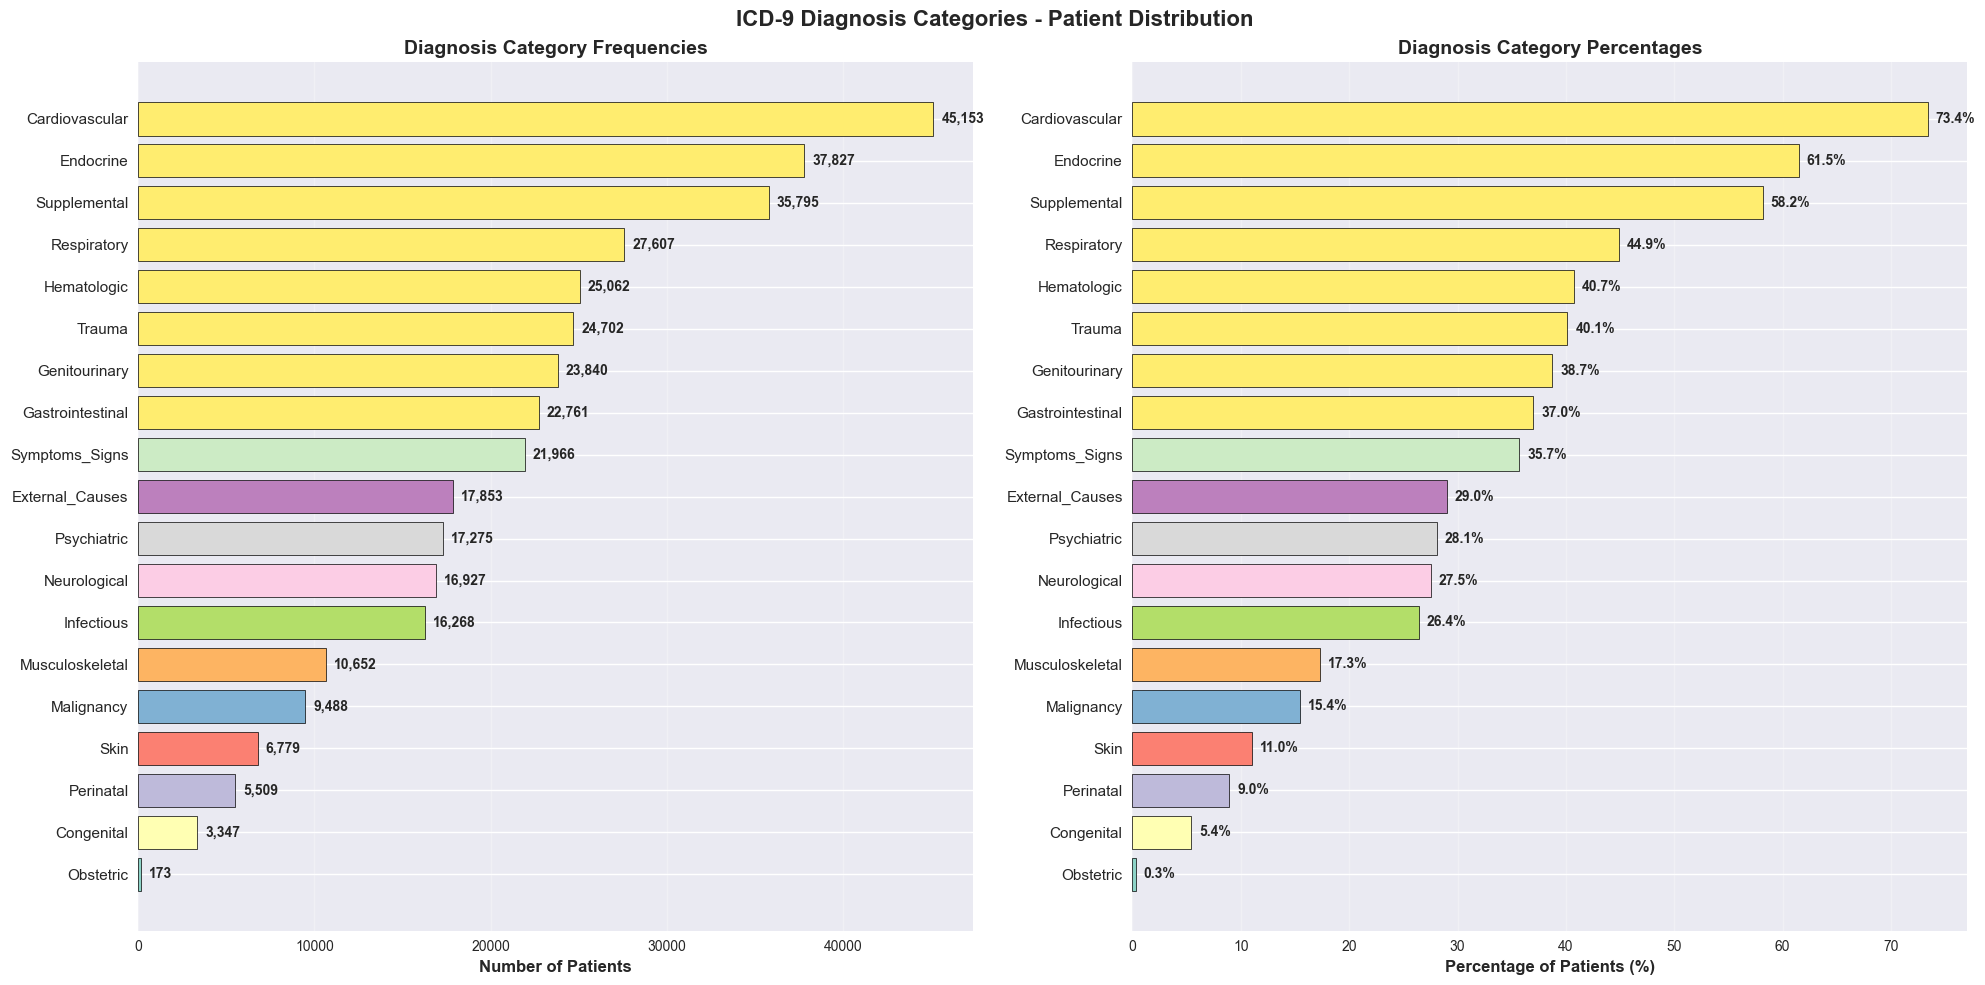


DIAGNOSIS CATEGORY SUMMARY
Total ICU patients analyzed: 61,532
Most common diagnosis category: Cardiovascular (73.4%)
Least common diagnosis category: Obstetric (0.3%)
Average patients per category: 19420
Median patients per category: 17853

Top 5 Most Common Categories:
  Hematologic: 25,062 patients (40.7%)
  Respiratory: 27,607 patients (44.9%)
  Supplemental: 35,795 patients (58.2%)
  Endocrine: 37,827 patients (61.5%)
  Cardiovascular: 45,153 patients (73.4%)

Bottom 5 Least Common Categories:
  Obstetric: 173 patients (0.3%)
  Congenital: 3,347 patients (5.4%)
  Perinatal: 5,509 patients (9.0%)
  Skin: 6,779 patients (11.0%)
  Malignancy: 9,488 patients (15.4%)


In [32]:
# Usage example:
category_data = visualize_diagnosis_categories(patients_with_segmented_diagnosis_df)

#### <b> Join CHART EVENTS and D_ITEMS </b>

* Get chart measurements details 

In [33]:
chart_events_df.show(5)

+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|        36| 165660|    241249|223834|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|223835|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|  100|   100.0|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224328|2134-05-12 12:00:00|2134-05-12 12:18:00|20823|  .37|    0.37|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224329|2134-05-12 12:00:00|2134-05-12 12:19:00|20823|    6|     6.0|     min|      0|    0|        NULL| 

In [34]:
d_items_df.show(5)

+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|ITEMID|               LABEL|ABBREVIATION|DBSOURCE|    LINKSTO|CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|   497|Patient controlle...|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   498|   PCA Lockout (Min)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   499|      PCA Medication|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   500|      PCA Total Dose|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   501|  PCV Exh Vt (Obser)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
only showing top 5 rows



In [35]:
chartevents_item_d_items = chart_events_df.join(d_items_df, on=["ITEMID"], how="left")

In [36]:
chartevents_item_d_items.show(5)

+------+----------+-------+----------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+--------------------+-----------------+----------+-----------+-------------+--------+----------+---------+
|ITEMID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|               LABEL|     ABBREVIATION|  DBSOURCE|    LINKSTO|     CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+----------+-------+----------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+--------------------+-----------------+----------+-----------+-------------+--------+----------+---------+
|223834|        36| 165660|    241249|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|             O2 Flow|          O2 Flow|metavision|chartevents|  Respiratory|   L/min|   Numeric|     NULL|


In [37]:
# Check database distribution for ICU chartevents only
icu_chartevents_db_dist = chart_events_df.filter(col("ICUSTAY_ID").isNotNull()) \
    .join(d_items_df, on="ITEMID") \
    .groupBy("DBSOURCE").count() \
    .orderBy(desc("count"))
icu_chartevents_db_dist.show()

+----------+---------+
|  DBSOURCE|    count|
+----------+---------+
|   carevue|221054208|
|metavision|109360746|
+----------+---------+



* <b> CareVue has the most data </b> 
* Since there are duplicate measurements that appear both in CareVue and MetaVision, we will opt to filter the data based on the patients that have info from the CareVue database

In [38]:
icu_chartevents_carevue = chartevents_item_d_items.filter(col("DBSOURCE") == "carevue")

In [39]:
icu_chartevents_carevue.select("ICUSTAY_ID").distinct().count()

37946

In [40]:
patients_with_segmented_diagnosis_df.select("ICUSTAY_ID").distinct().count()

61532